In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("<style>.container { width: 90% !important; }</style>")

In [2]:
import IPython

import io
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import PIL
import cv2

import sneks
import gym

import torch
import torch.nn as nn

plt.style.use('default')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.__version__, DEVICE, gym.__version__

('1.3.1', 'cuda', '0.17.1')

In [3]:
# Necessary to display cartpole and other envs headlessly
# https://stackoverflow.com/a/47968021
from pyvirtualdisplay.smartdisplay import SmartDisplay as Display

display = Display(visible=0, size=(1400, 900))
display.start()

import os
os.environ['DISPLAY']

':1017'

In [4]:
# env = gym.make('snek-rgb-16-v1')
env = gym.make('CartPole-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

num_actions = env.action_space.n
obs_size = np.prod(env.observation_space.shape)

obs_size, num_actions, env.reward_range, # env.unwrapped.unwrapped.get_action_meanings()

(4, 2, (-inf, inf))

In [5]:
# https://github.com/NicksonYap/Jupyter-Webcam/blob/master/Realtime_video_ipython_py3.ipynb
def show_array(a, prev_display_id=None, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    IPython.display.display(obj)
    
def clear_display():
    IPython.display.clear_output(wait=True)

In [6]:
def show_live_env(env, controller, duration=100, fps=100):
    total_frames = 0
    try:
        while True:
            obs = env.reset()
            done = False

            while not done:
                total_frames += 1
                time.sleep(1 / fps)                

                action = controller(obs)
                obs, reward, done, _ = env.step(action)

                frame = env.render('rgb_array')
                frame = cv2.resize(frame, (256, 265))

                clear_display()
                show_array(frame)
                
                if total_frames > duration: return

    except KeyboardInterrupt as e:
        clear_display()
        show_array(frame) # show last frame

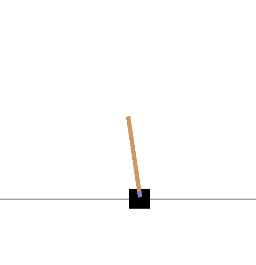

In [7]:
show_live_env(env, lambda o: env.action_space.sample(), duration=100, fps=200)

# Utils

In [8]:
def dense(i, o, a=nn.Sigmoid):
    l = nn.Linear(i, o)
    return nn.Sequential(l, a())

def lam(func):
    class Lambda(nn.Module):
        def forward(self, *args):
            return func(*args)

    return Lambda()

In [9]:
# net = nn.Sequential(
#     lam(lambda x: x.permute(0, 3, 1, 2)),
#     nn.Conv2d(3, 128, kernel_size=2, stride=1),
#     nn.ReLU(),
#     nn.Conv2d(128, 128, kernel_size=2, stride=1),
#     nn.ReLU(),
#     nn.Conv2d(128, 64, kernel_size=3, stride=1),
#     nn.ReLU(),
#     nn.Conv2d(64, 32, kernel_size=3, stride=1),
#     nn.ReLU(),
#     nn.Conv2d(32, 16, kernel_size=4, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Linear(256, 32),
#     nn.ReLU(),
#     nn.Linear(32, 4),
# )

# t = torch.rand(4, 16, 16, 3)
# net(t).shape

# Model

In [10]:
class DQN(nn.Module):
    def __init__(self, obs_size, num_actions):
        super(DQN, self).__init__()

        hidden_dim = 128
        def make_dqn():
            return nn.Sequential(
                nn.Flatten(),
                dense(obs_size, hidden_dim, nn.ReLU),
                dense(hidden_dim, hidden_dim, nn.ReLU),
                nn.Linear(hidden_dim, num_actions),
            ).to(DEVICE)

        self.eval_net = make_dqn()
        self.target_net = make_dqn().eval()

    def forward(self, obs):
        return self.eval_net(obs)

    def get_max_action(self, obs):
        obs = torch.FloatTensor([obs]).to(DEVICE)
        q_vals = self.target_net(obs)[0]
        return q_vals.argmax().cpu().detach().numpy()
    
    def replace_target(self):
        self.target_net.load_state_dict(self.eval_net.state_dict())


dqn = DQN(obs_size, num_actions)

In [11]:
# https://github.com/cyoon1729/deep-Q-networks/blob/master/vanillaDQN/dqn.py#L51
def dqn_loss(i, model, batch):
    discount = 0.95
    criterion = nn.MSELoss()

    if i % 50:
        model.replace_target()

    obs, actions, rewards, next_obs, done = batch
    obs = torch.FloatTensor(obs).to(DEVICE)
    actions = torch.LongTensor(actions).to(DEVICE)
    rewards = torch.FloatTensor(rewards).to(DEVICE)
    next_obs = torch.FloatTensor(next_obs).to(DEVICE)
    done = torch.BoolTensor(done).to(DEVICE)

    q_vals = model(obs).gather(dim=1, index=actions.unsqueeze(0).T).squeeze()
    next_q_vals, _ = model.target_net(next_obs).max(dim=1)
    target_q_vals = next_q_vals * discount + rewards
    target_q_vals[done] = rewards[done]

    return criterion(q_vals, target_q_vals)

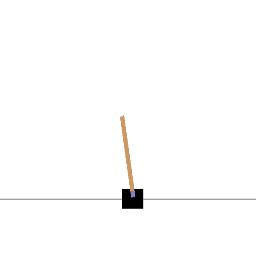

In [12]:
show_live_env(env, lambda obs: dqn.get_max_action(obs), duration=80, fps=200)

# Experience provider

In [13]:
from collections import deque

def get_experience_generator(env, model, bs):
    max_rollout_steps = 500
    buffer_size = 100_000
    randomness = 1
    randomness_min = 0.01
    randomness_decay = 0.998

    episode_rewards = []
    randomness_list = []
    experience_pool = deque(maxlen=buffer_size)

    while True:
        obs = env.reset()
        done = False
        step = 0
        episode_rewards.append(0)

        while not done and step < max_rollout_steps:
            randomness = max(randomness_min, randomness * randomness_decay)
            randomness_list.append(randomness)
            step += 1

            use_model = random.uniform(0, 1) > randomness
            if use_model:
                action = model.get_max_action(obs)
            else:
                action = env.action_space.sample()

            next_obs, reward, done, _info = env.step(action)
            experience_pool.append((obs, action, reward, next_obs, done))
            obs = next_obs
            episode_rewards[-1] += reward

            if len(experience_pool) >= bs:
                batch = random.sample(experience_pool, bs)
                yield [np.array(t) for t in zip(*batch)], episode_rewards, randomness_list


generator = get_experience_generator(env, dqn, bs=100)
batch, episode_rewards, _ = next(generator)
[t.shape for t in batch], episode_rewards

([(100, 4), (100,), (100,), (100, 4), (100,)],
 [21.0, 12.0, 17.0, 25.0, 24.0, 1.0])

# Training

In [14]:
def dqn_optimize(env, model, its, next_batch, lr):
    tr = trange(its, bar_format="{bar}{l_bar}{r_bar}")
    fig, ((ax_loss, ax_reward, ax_eps)) = plt.subplots(1, 3, figsize=(16, 5))
    losses = []
    loss_avgs = []
    it_ids = []

    optimizer = torch.optim.Adam(params=model.eval_net.parameters(), lr=lr)

    for i in tr:
        it_ids.append(i)
        batch, episode_rewards, randomness_list = next(next_batch)

        optimizer.zero_grad()
        loss = dqn_loss(i, model, batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        loss_avgs.append(np.mean(losses[-20:]))

        description = [
            'it %i/%i' % (i + 1, its),
            'loss: %.6f' % loss.item(),
            'reward moving avg: %.2f' % np.mean(episode_rewards[-50:-1]),
            ' #### ',
        ]

        ax_loss.clear()
        ax_loss.plot(it_ids[-500:], losses[-500:], linewidth=1)
        ax_loss.plot(it_ids[-500:], loss_avgs[-500:], linewidth=2)

        
        ax_reward.clear()
        ax_reward.plot(episode_rewards[:-1], linewidth=2)

        ax_eps.clear()
        ax_eps.plot(randomness_list, linewidth=2)
        
        fig.canvas.draw()

        tr.set_description(' | '.join(description))

In [15]:
# env = gym.make('snek-rgb-16-v1')
env = gym.make('CartPole-v1')

num_actions = env.action_space.n
obs_size = np.prod(env.observation_space.shape)

dqn = DQN(obs_size, num_actions)

<IPython.core.display.Javascript object>


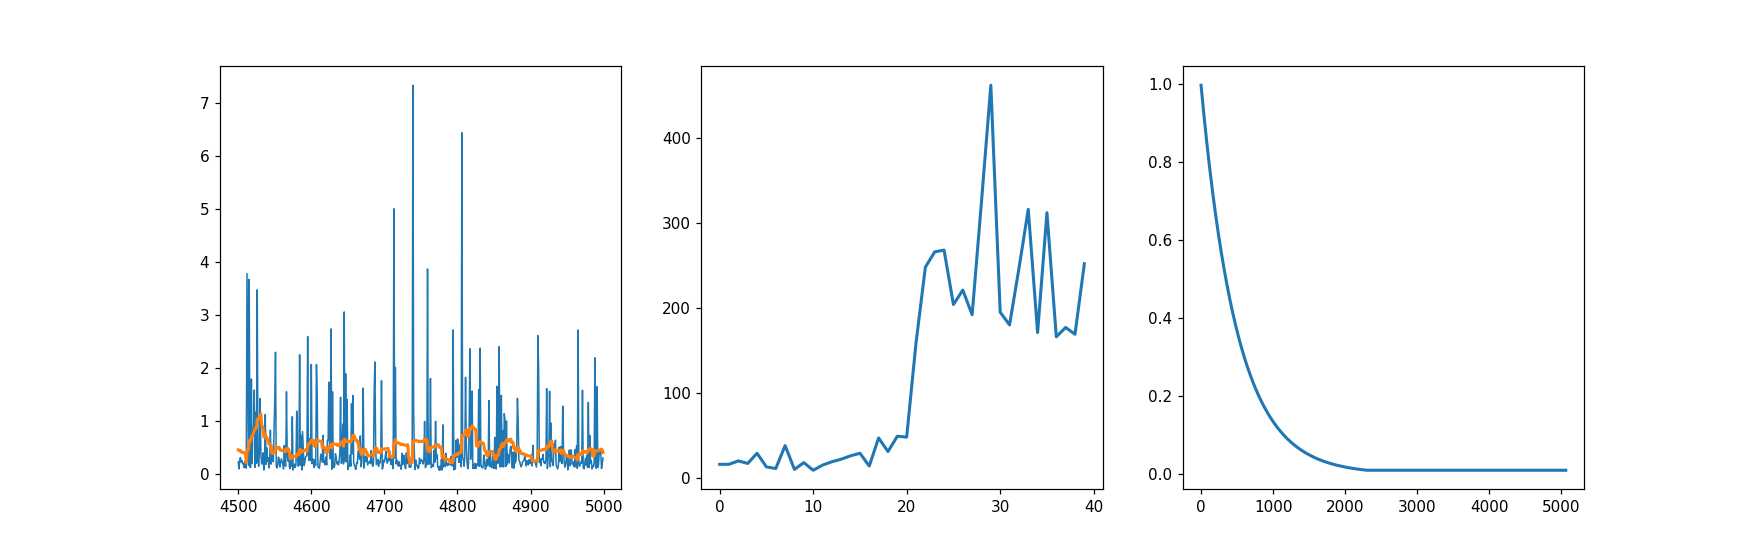

In [16]:
%matplotlib notebook

dqn_optimize(
    env=env,
    model=dqn,
    its=5000,
    lr=0.001,
    next_batch=get_experience_generator(
        env,
        dqn,
        bs=64,
    ),
)

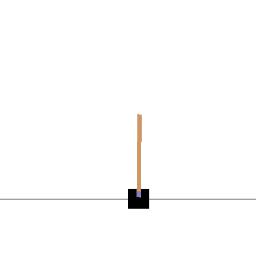

In [19]:
show_live_env(env, lambda obs: dqn.get_max_action(obs), duration=800, fps=200)